In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
!pip install kaggle


In [13]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vikranthjakamukala","key":"de7d21ace89edead9c37fb88d822a2b0"}'}

In [14]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [16]:
!kaggle competitions download -c nyc-taxi-trip-duration


 86% 74.0M/85.8M [00:00<00:00, 104MB/s] 
100% 85.8M/85.8M [00:01<00:00, 76.6MB/s]


In [17]:
!unzip nyc-taxi-trip-duration.zip


Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


In [19]:
!unzip train.zip


Archive:  train.zip
  inflating: train.csv               


In [6]:
import pandas as pd

# Load the training dataset
data = pd.read_csv('train.csv')
print(data.head())


          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   
1                1            -73.98            40.74             -74.00   
2                1            -73.98            40.76             -74.01   
3                1            -74.01            40.72             -74.01   
4                1            -73.97            40.79             -73.97   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0             40.77                  N            455  
1             40

In [7]:
print(f"Dataset Shape: {data.shape}")
print(data.info())


Dataset Shape: (1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None


In [8]:
print("Missing values per column:")
print(data.isnull().sum())


Missing values per column:
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [9]:
print(data.describe())


         vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1,458,644.00     1,458,644.00      1,458,644.00     1,458,644.00   
mean          1.53             1.66            -73.97            40.75   
std           0.50             1.31              0.07             0.03   
min           1.00             0.00           -121.93            34.36   
25%           1.00             1.00            -73.99            40.74   
50%           2.00             1.00            -73.98            40.75   
75%           2.00             2.00            -73.97            40.77   
max           2.00             9.00            -61.34            51.88   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1,458,644.00      1,458,644.00   1,458,644.00  
mean              -73.97             40.75         959.49  
std                 0.07              0.04       5,237.43  
min              -121.93             32.18           1.00  
25%               -73.99         

In [10]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])


In [11]:
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek


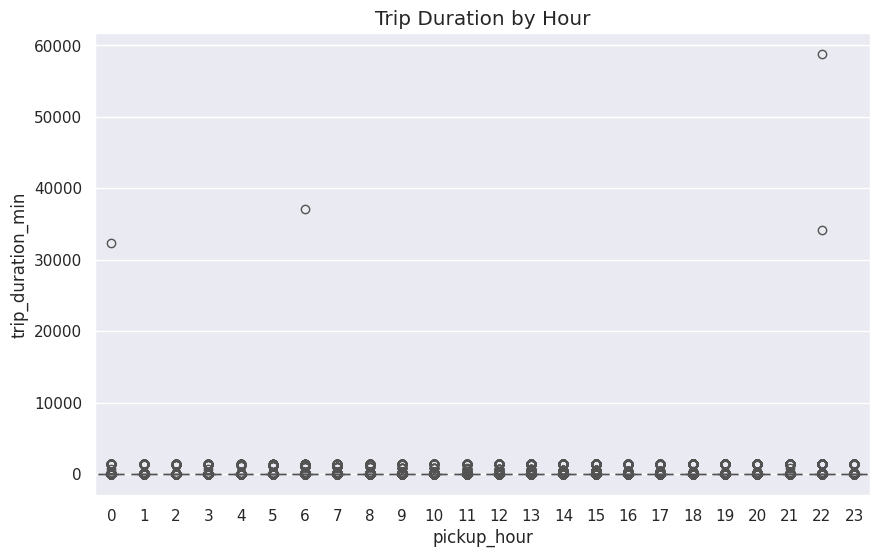

In [12]:
data['trip_duration_min'] = data['trip_duration'] / 60  # Convert to minutes
sns.boxplot(x='pickup_hour', y='trip_duration_min', data=data)
plt.title("Trip Duration by Hour")
plt.show()


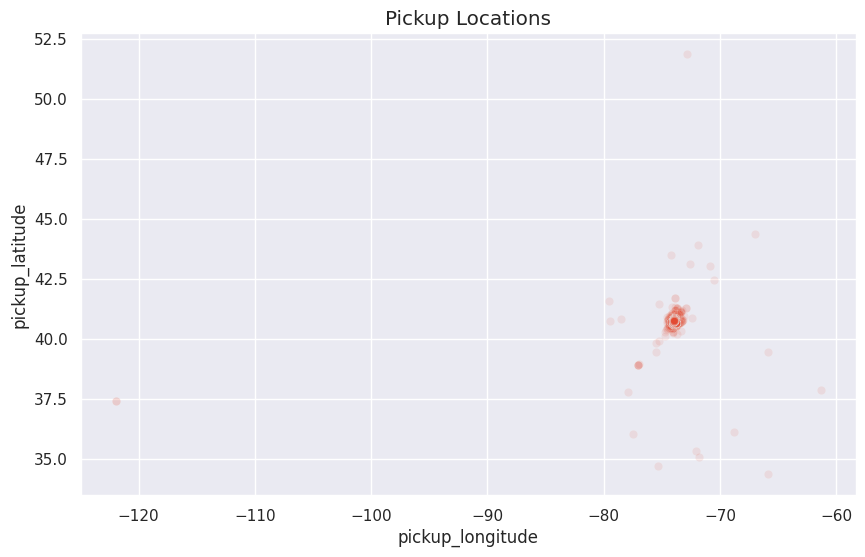

In [13]:
sns.scatterplot(
    x='pickup_longitude', y='pickup_latitude', data=data, alpha=0.1
)
plt.title("Pickup Locations")
plt.show()


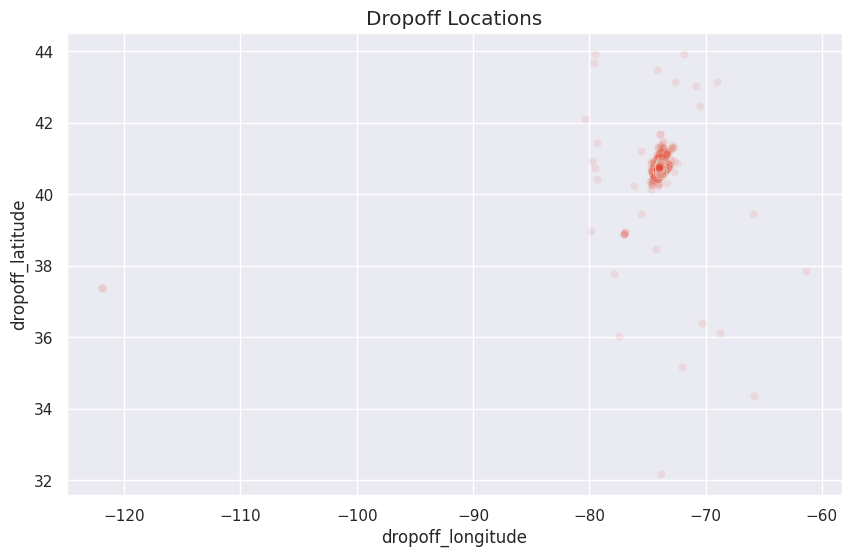

In [14]:
sns.scatterplot(
    x='dropoff_longitude', y='dropoff_latitude', data=data, alpha=0.1
)
plt.title("Dropoff Locations")
plt.show()


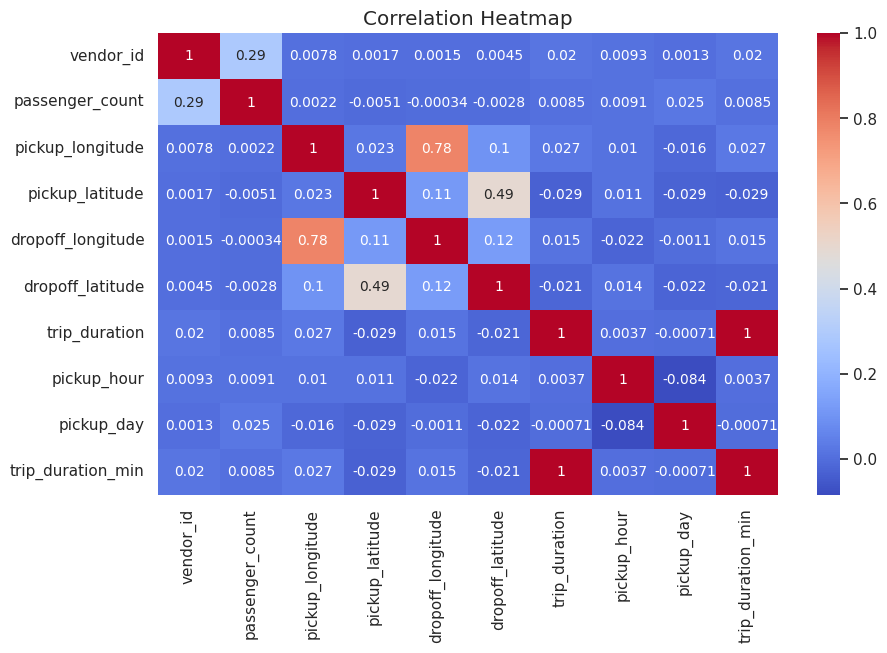

In [15]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


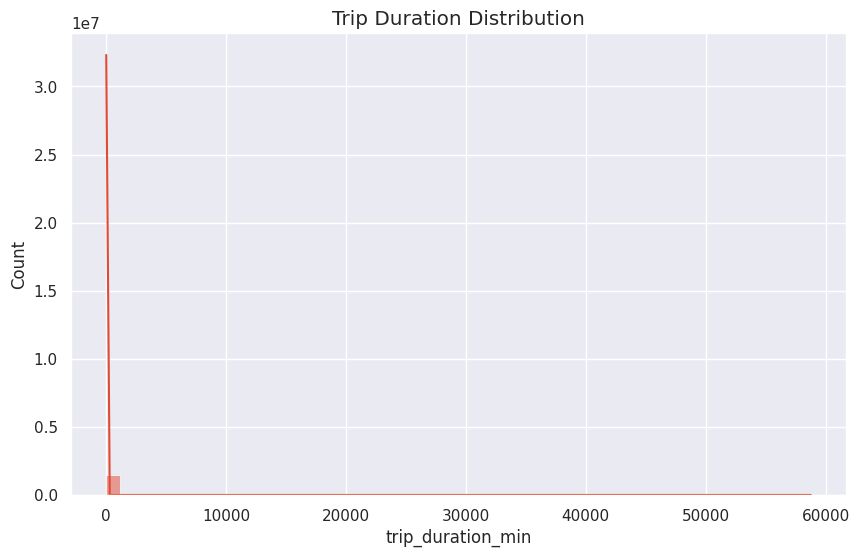

In [16]:
sns.histplot(data['trip_duration_min'], bins=50, kde=True)
plt.title('Trip Duration Distribution')
plt.show()


In [17]:
#data cleaning and preprocessing
data.fillna(data.median(), inplace=True)
data = data[(data['trip_duration_min'] > 1) & (data['trip_duration_min'] < 120)]


In [18]:
from scipy.stats import zscore
data['zscore'] = zscore(data['trip_duration_min'])
data = data[data['zscore'].abs() < 3]


In [19]:
from geopy.distance import geodesic
data['distance'] = data.apply(
    lambda row: geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).km, axis=1
)


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['distance', 'trip_duration_min']] = scaler.fit_transform(data[['distance', 'trip_duration_min']])


In [21]:
data = pd.get_dummies(data, columns=['vendor_id', 'store_and_fwd_flag'], drop_first=True)


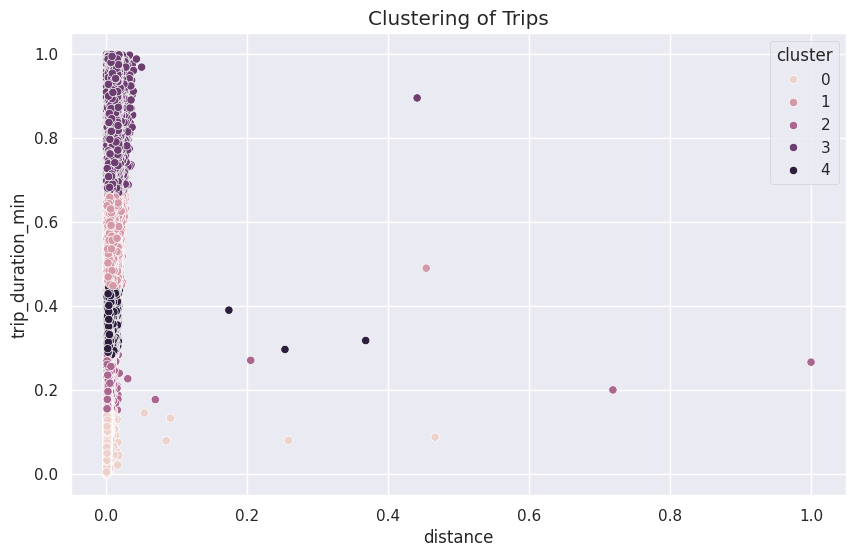

In [22]:
#clustering K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['distance', 'trip_duration_min']])
sns.scatterplot(x='distance', y='trip_duration_min', hue='cluster', data=data)
plt.title('Clustering of Trips')
plt.show()


In [23]:
#anomaly detection
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01)
data['anomaly'] = iso.fit_predict(data[['distance', 'trip_duration_min']])
data = data[data['anomaly'] == 1]  # Keep non-anomalous data


In [24]:
#model building: train-test split
from sklearn.model_selection import train_test_split
X = data.drop(['trip_duration', 'pickup_datetime', 'dropoff_datetime'], axis=1)
y = data['trip_duration_min']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
!pip install autoviml


In [1]:
!pip install scikit-learn==1.2.2
!pip install imbalanced-learn==0.9.1

In [2]:
!pip install --upgrade --force-reinstall autoviml pandas==1.3.3 scikit-learn==0.24.2 numpy==1.21.2


  Using cached autoviml-0.1.800-py3-none-any.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
!pip uninstall scipy -y


Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1


In [1]:
!pip install scipy==1.7.3


In [1]:
!pip install --upgrade --force-reinstall numpy==1.23

  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.7.3 which is incompatible.
arviz 0.20.0 requires scipy>=1.9.0, but you have scipy 1.7.3 which is incompatible.
autoviml 0.1.800 requires imbalanced-learn>=0.10.1, but you have imbalanced-learn 0.9.1 which is incompatible.
a

==================== System Information ====================
System: Linux
Node Name: 6e3c9b2211d7
Release: 6.1.85+
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Machine: x86_64
Processor: x86_64
====================== CPU Information ======================
Physical cores: 1
Total cores: 2
==================== Memory Information ====================
Total: 12.67GB
Available: 9.89GB
Used: 2.45GB
##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise, Random Forests will take too long for 10,000+ rows
Training Set Shape = (1124388, 15)
    Training Set Memory Usage = 117.95 MB
Test Set Shape = (281097, 15)
    Test Set Memory Usage = 29.49 MB
Single_Label Target: ['trip_duration_min']
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
###############################################################################

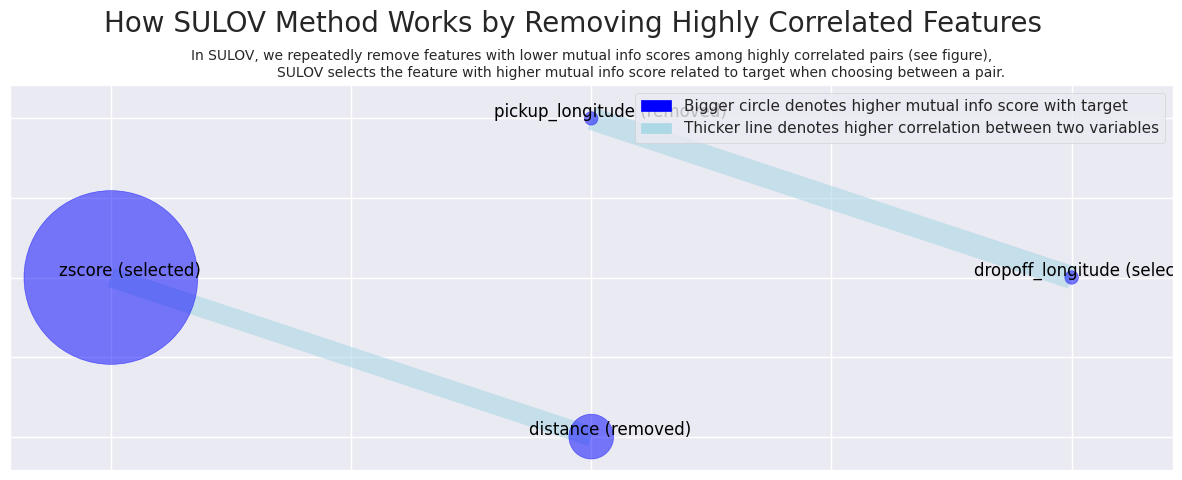

Splitting selected features into float and categorical (integer) variables:
    (4) float variables ...
    (6) categorical vars...
###############################################################################
#######     F E A T U R E   S E L E C T I O N    BY   X G B O O S T    ########
###############################################################################
Current number of predictors = 10 
    Finding Important Features using Boosted Trees algorithm...
        using 10 variables...
        using 8 variables...
        using 6 variables...
        using 4 variables...
        using 2 variables...
Found 10 important features
    Performing limited feature engineering for binning, add_poly and KMeans_Featurizer flags  ...
    Train CV Split completed with TRAIN rows =  899510 , CV rows =  224878
    Binning_Flag set to False or there are no float vars in data set to be binned
    KMeans_Featurizer set to False or there are no float variables in data
Performing MinMax scaling

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)
<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm =

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.HTML object>
Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


    Actual training time (in seconds): 3436
###########  Single_Label  M O D E L   R E S U L T S #################
5-fold Cross Validation rmse Score = 0.0049
    Best Parameters for Model = {'C': 23.504378152453466, 'epsilon': 0.0065530026811640996}
########################################################
Linear Model Prediction Results on Held Out CV Data Set:
Regression Plots completed in 0.113 seconds
    MAE = 0.0047
    MAPE = 5% (MAPE will be very high when zeros in actuals)
    RMSE = 0.0049
    Normalized MAE (as % std dev of Actuals) = 3%
    Normalized RMSE (% of Std Dev of Actuals) = 3%
Could not plot Cross Validation Parameters
    Time taken for this Target (in seconds) = 3816
    Binning_Flag set to False or there are no float vars in data set to be binned
Performing MinMax scaling of train and test data...
###########################################################################
#####   F I N A L I Z I N G   M O D E L   O N    F U L L   T R A I N  #####
##############

Could not plot SHAP values since SHAP is not installed or could not import SHAP in this machine
############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 5450
Writing Output files to disk...
    Saving predictions to ./trip_duration_min/trip_duration_min_Regression_test_modified.csv
    Saving predictions to ./trip_duration_min/trip_duration_min_Regression_submission.csv
    Saving predictions to ./trip_duration_min/trip_duration_min_Regression_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 91.2 for the Entire Process


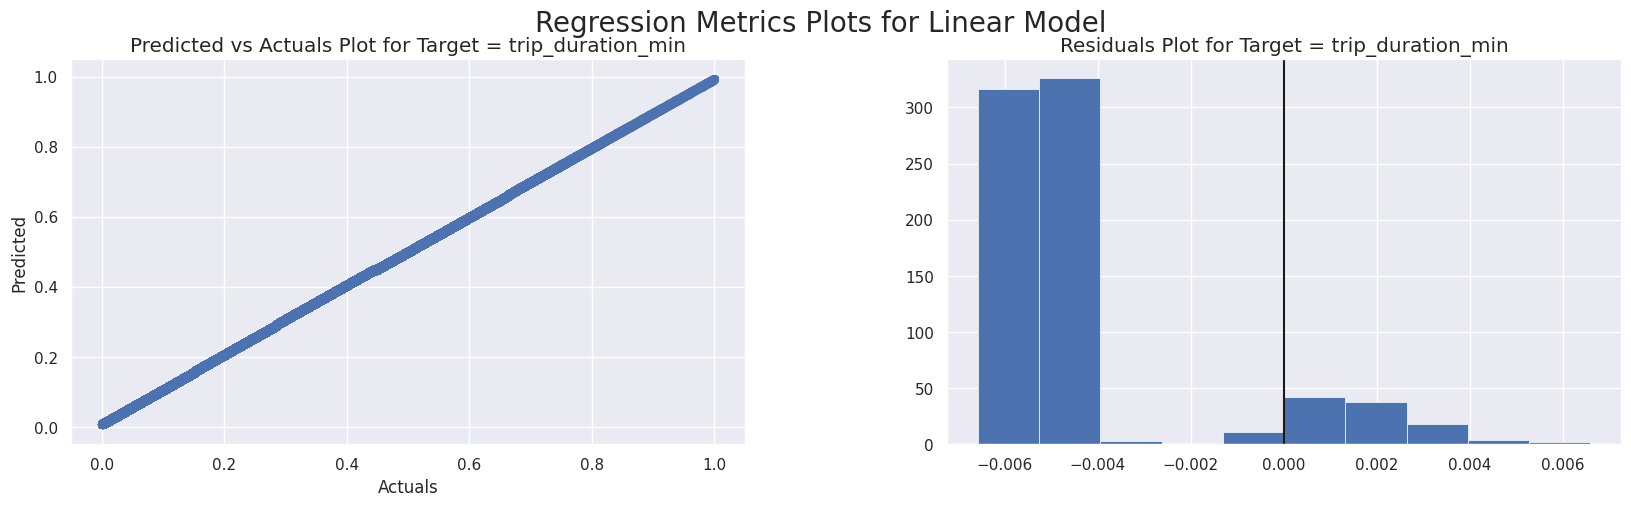

<Figure size 1500x500 with 0 Axes>

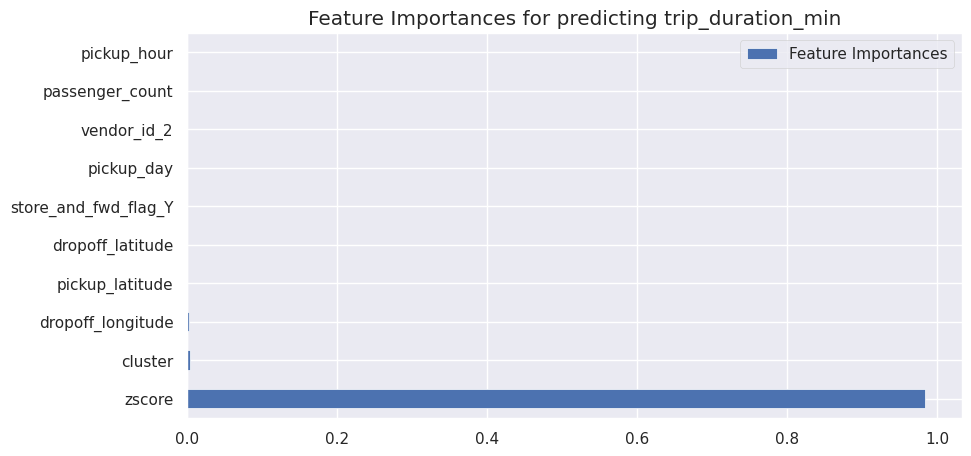

In [25]:
from autoviml.Auto_ViML import Auto_ViML

model, features, train, test = Auto_ViML(
    train=X_train, test=X_test, target='trip_duration_min', verbose=2
)
